In [1]:
import Pkg; 

if split(pwd(),"/")[end] == "hmc"
    cd(joinpath(@__DIR__, "../../"))
    Pkg.activate("Project.toml")
end

using MorphoMol

using CairoMakie
using LinearAlgebra
using Random
using Rotations
using StaticArrays
using Distributions
using Distances

  Activating project at `~/Doktor/Code/MorphoMol/MorphoMol.jl`


In [2]:
function rotation_and_translation_gradient!(∇E, x, ∇FSol, template_mol)
    n_atoms_per_mol = size(template_mol)[2]
    n_mol = length(x) ÷ 6
    for i in 1:n_mol        
        R = exp(Rotations.RotationVecGenerator(x[(i-1)*6 + 1:(i-1)*6 + 3]...))
        ∇E[(i-1) * 6 + 1] = 0.5 * sum([-v[2]*(R[3,:] ⋅ w) + v[3]*(R[2,:] ⋅ w) for (v,w) in [(∇FSol[:,:,i][:,j], template_mol[:,j]) for j in 1:n_atoms_per_mol]])
        ∇E[(i-1) * 6 + 2] = 0.5 * sum([v[1]*(R[3,:] ⋅ w) - v[3]*(R[1,:] ⋅ w) for (v,w) in [(∇FSol[:,:,i][:,j], template_mol[:,j]) for j in 1:n_atoms_per_mol]])
        ∇E[(i-1) * 6 + 3] = 0.5 * sum([-v[1]*(R[2,:] ⋅ w) + v[2]*(R[1,:] ⋅ w) for (v,w) in [(∇FSol[:,:,i][:,j], template_mol[:,j]) for j in 1:n_atoms_per_mol]])
        ∇E[(i-1) * 6 + 4:(i-1) * 6 + 6] = sum([∇FSol[:,j,i] for j in 1:n_atoms_per_mol])
    end
    ∇E
end

function solvation_free_energy_gradient!(∇E, x, template_mol, radii, rs, pf, overlap_slope)
    n_atoms_per_mol = size(template_mol)[2]
    n_mol = length(x) ÷ 6
    flat_realization = MorphoMol.Utilities.get_flat_realization(x, template_mol)
    _, dvol, dsurf, dmean, dgauss, dlol = MorphoMol.Energies.get_geometric_measures_and_overlap_value_with_derivatives(
        flat_realization,
        n_atoms_per_mol,
        radii,
        rs,
        0.0,
        overlap_slope
    )
    ∇FSol = reshape(pf[1] * dvol + pf[2] * dsurf + pf[3] * dmean + pf[4] * dgauss + dlol, (3, n_atoms_per_mol, n_mol))
    rotation_and_translation_gradient!(∇E, x, ∇FSol, template_mol)
end


solvation_free_energy_gradient! (generic function with 1 method)

In [3]:
function solvation_free_energy(x::Vector{Float64}, template_mol::Matrix{Float64}, radii::Vector{Float64}, rs::Float64, prefactors::AbstractVector, overlap_jump::Float64, overlap_slope::Float64, delaunay_eps::Float64)
    n_mol = length(x) ÷ 6
    n_atoms_per_mol = size(template_mol)[2]
    flat_realization = MorphoMol.Utilities.get_flat_realization(x, template_mol)
    MorphoMol.Energies.solvation_free_energy(flat_realization, n_atoms_per_mol, radii, rs, prefactors, overlap_jump, overlap_slope, delaunay_eps)
end

function solvation_free_energy_and_measures(x::Vector{Float64}, template_mol::Matrix{Float64}, radii::Vector{Float64}, rs::Float64, prefactors::AbstractVector, overlap_jump::Float64, overlap_slope::Float64, delaunay_eps::Float64)
    n_mol = length(x) ÷ 6
    n_atoms_per_mol = size(template_mol)[2]
    flat_realization = MorphoMol.Utilities.get_flat_realization(x, template_mol)
    measures = MorphoMol.Energies.get_geometric_measures_and_overlap_value(flat_realization, n_atoms_per_mol, radii, rs, overlap_jump, overlap_slope, delaunay_eps)
    sum(measures .* [prefactors; 1.0]), Dict{String,Any}("Vs" => measures[1], "As" => measures[2], "Cs" => measures[3], "Xs" => measures[4], "OLs" => measures[5])
end

solvation_free_energy_and_measures (generic function with 1 method)

In [4]:
mol_type = "6r7m"
template_centers = MorphoMol.Utilities.TMV_TEMPLATES[mol_type]["template_centers"]
template_radii = MorphoMol.Utilities.TMV_TEMPLATES[mol_type]["template_radii"]
n_mol = 2
bounds = 80.0
x_init = MorphoMol.Utilities.get_initial_state(n_mol, bounds)
n_atoms_per_mol = length(template_radii)
radii = vcat([template_radii for i in 1:n_mol]...);

In [5]:
T = 0.8
ε = 0.0025
L = 7
β = 1.0 / T

rs = 1.4
eta = 0.3665
pf = MorphoMol.Energies.get_prefactors(rs, eta)
overlap_slope = 0.85

σ_r = 0.75
σ_t = 1.25

Σ = vcat([[σ_r, σ_r, σ_r, σ_t, σ_t, σ_t] for _ in 1:n_mol]...)

energy(x) = solvation_free_energy_and_measures(x, template_centers, radii, rs, pf, 0.0, overlap_slope, 1.0)
energy_gradient!(∇E, x) = solvation_free_energy_gradient!(∇E, x, template_centers, radii, rs, pf, overlap_slope)

output = Dict{String, Vector}(
    "states" => Vector{Vector{Float64}}([]),
    "Es" => Vector{Float64}([]), 
    "Vs" => Vector{Float64}([]), 
    "As" => Vector{Float64}([]), 
    "Cs" => Vector{Float64}([]), 
    "Xs" => Vector{Float64}([]),
    "OLs" => Vector{Float64}([]),
    "αs" => Vector{Float32}([]),
)

hmc = MorphoMol.Algorithms.HamiltonianMonteCarlo(energy, energy_gradient!, MorphoMol.Algorithms.standard_leapfrog!, β, L, ε, Σ)
simulation_time_minutes = 1.0
MorphoMol.Algorithms.simulate!(hmc, deepcopy(x_init), simulation_time_minutes, output);
output["αs"][end]

0.4375f0

In [6]:
println("Initial energy: $(output["Es"][1]) | final energy: $(output["Es"][end]) | minimal energy: $(minimum(output["Es"]))")

Initial energy: 8949.096132795728 | final energy: 8756.41978662117 | minimal energy: 8756.41978662117


In [7]:
try
    rm("assets/output", recursive = true)
catch 
end
mkpath("assets/output")
for (i, state) in enumerate(output["states"])
    MorphoMol.Utilities.state_to_poly(MorphoMol.Utilities.get_flat_realization(state, template_centers), radii, "assets/output/$(i)", n_mol, n_atoms_per_mol)
end

In [10]:
function generate_ouput_plots(sim_out)
    paired_colors = cgrad(:Paired_12, 12, categorical = true)
    xs = 1:length(sim_out["Vs"])

    pt_per_in = 72
    width =  5*5
    height = 5*3
    f_size = (pt_per_in * width, pt_per_in * height)
    fs = 15
    border_width = 0.5
    fig = Figure(size = f_size, fontsize = fs)
    ms = 4
    scatter(fig[1, 1], xs, sim_out["Vs"], markersize = ms, color = paired_colors[1], axis = (ylabel = L"V", ylabelrotation = 0,))
    scatter(fig[1, 2], xs, sim_out["As"], markersize = ms, color = paired_colors[3], axis = (ylabel = L"A", ylabelrotation = 0,))
    scatter(fig[1, 3], xs, sim_out["Cs"], markersize = ms, color = paired_colors[5], axis = (ylabel = L"C", ylabelrotation = 0,))
    scatter(fig[1, 4], xs, sim_out["Xs"], markersize = ms, color = paired_colors[7], axis = (ylabel = L"X", ylabelrotation = 0,))
    scatter(fig[2, 1], xs, sim_out["OLs"], markersize = ms, color = paired_colors[10], axis = (ylabel = L"OL", ylabelrotation = 0,))
    scatter(fig[2, 2], xs, sim_out["Es"], markersize = ms, color = paired_colors[12], axis = (ylabel = L"F_{sol}", ylabelrotation = 0,))
    #save(string("$(save_dir)/hmc_output_plots.png"), fig, pt_per_unit = 1)
    fig
end

generate_ouput_plots (generic function with 2 methods)

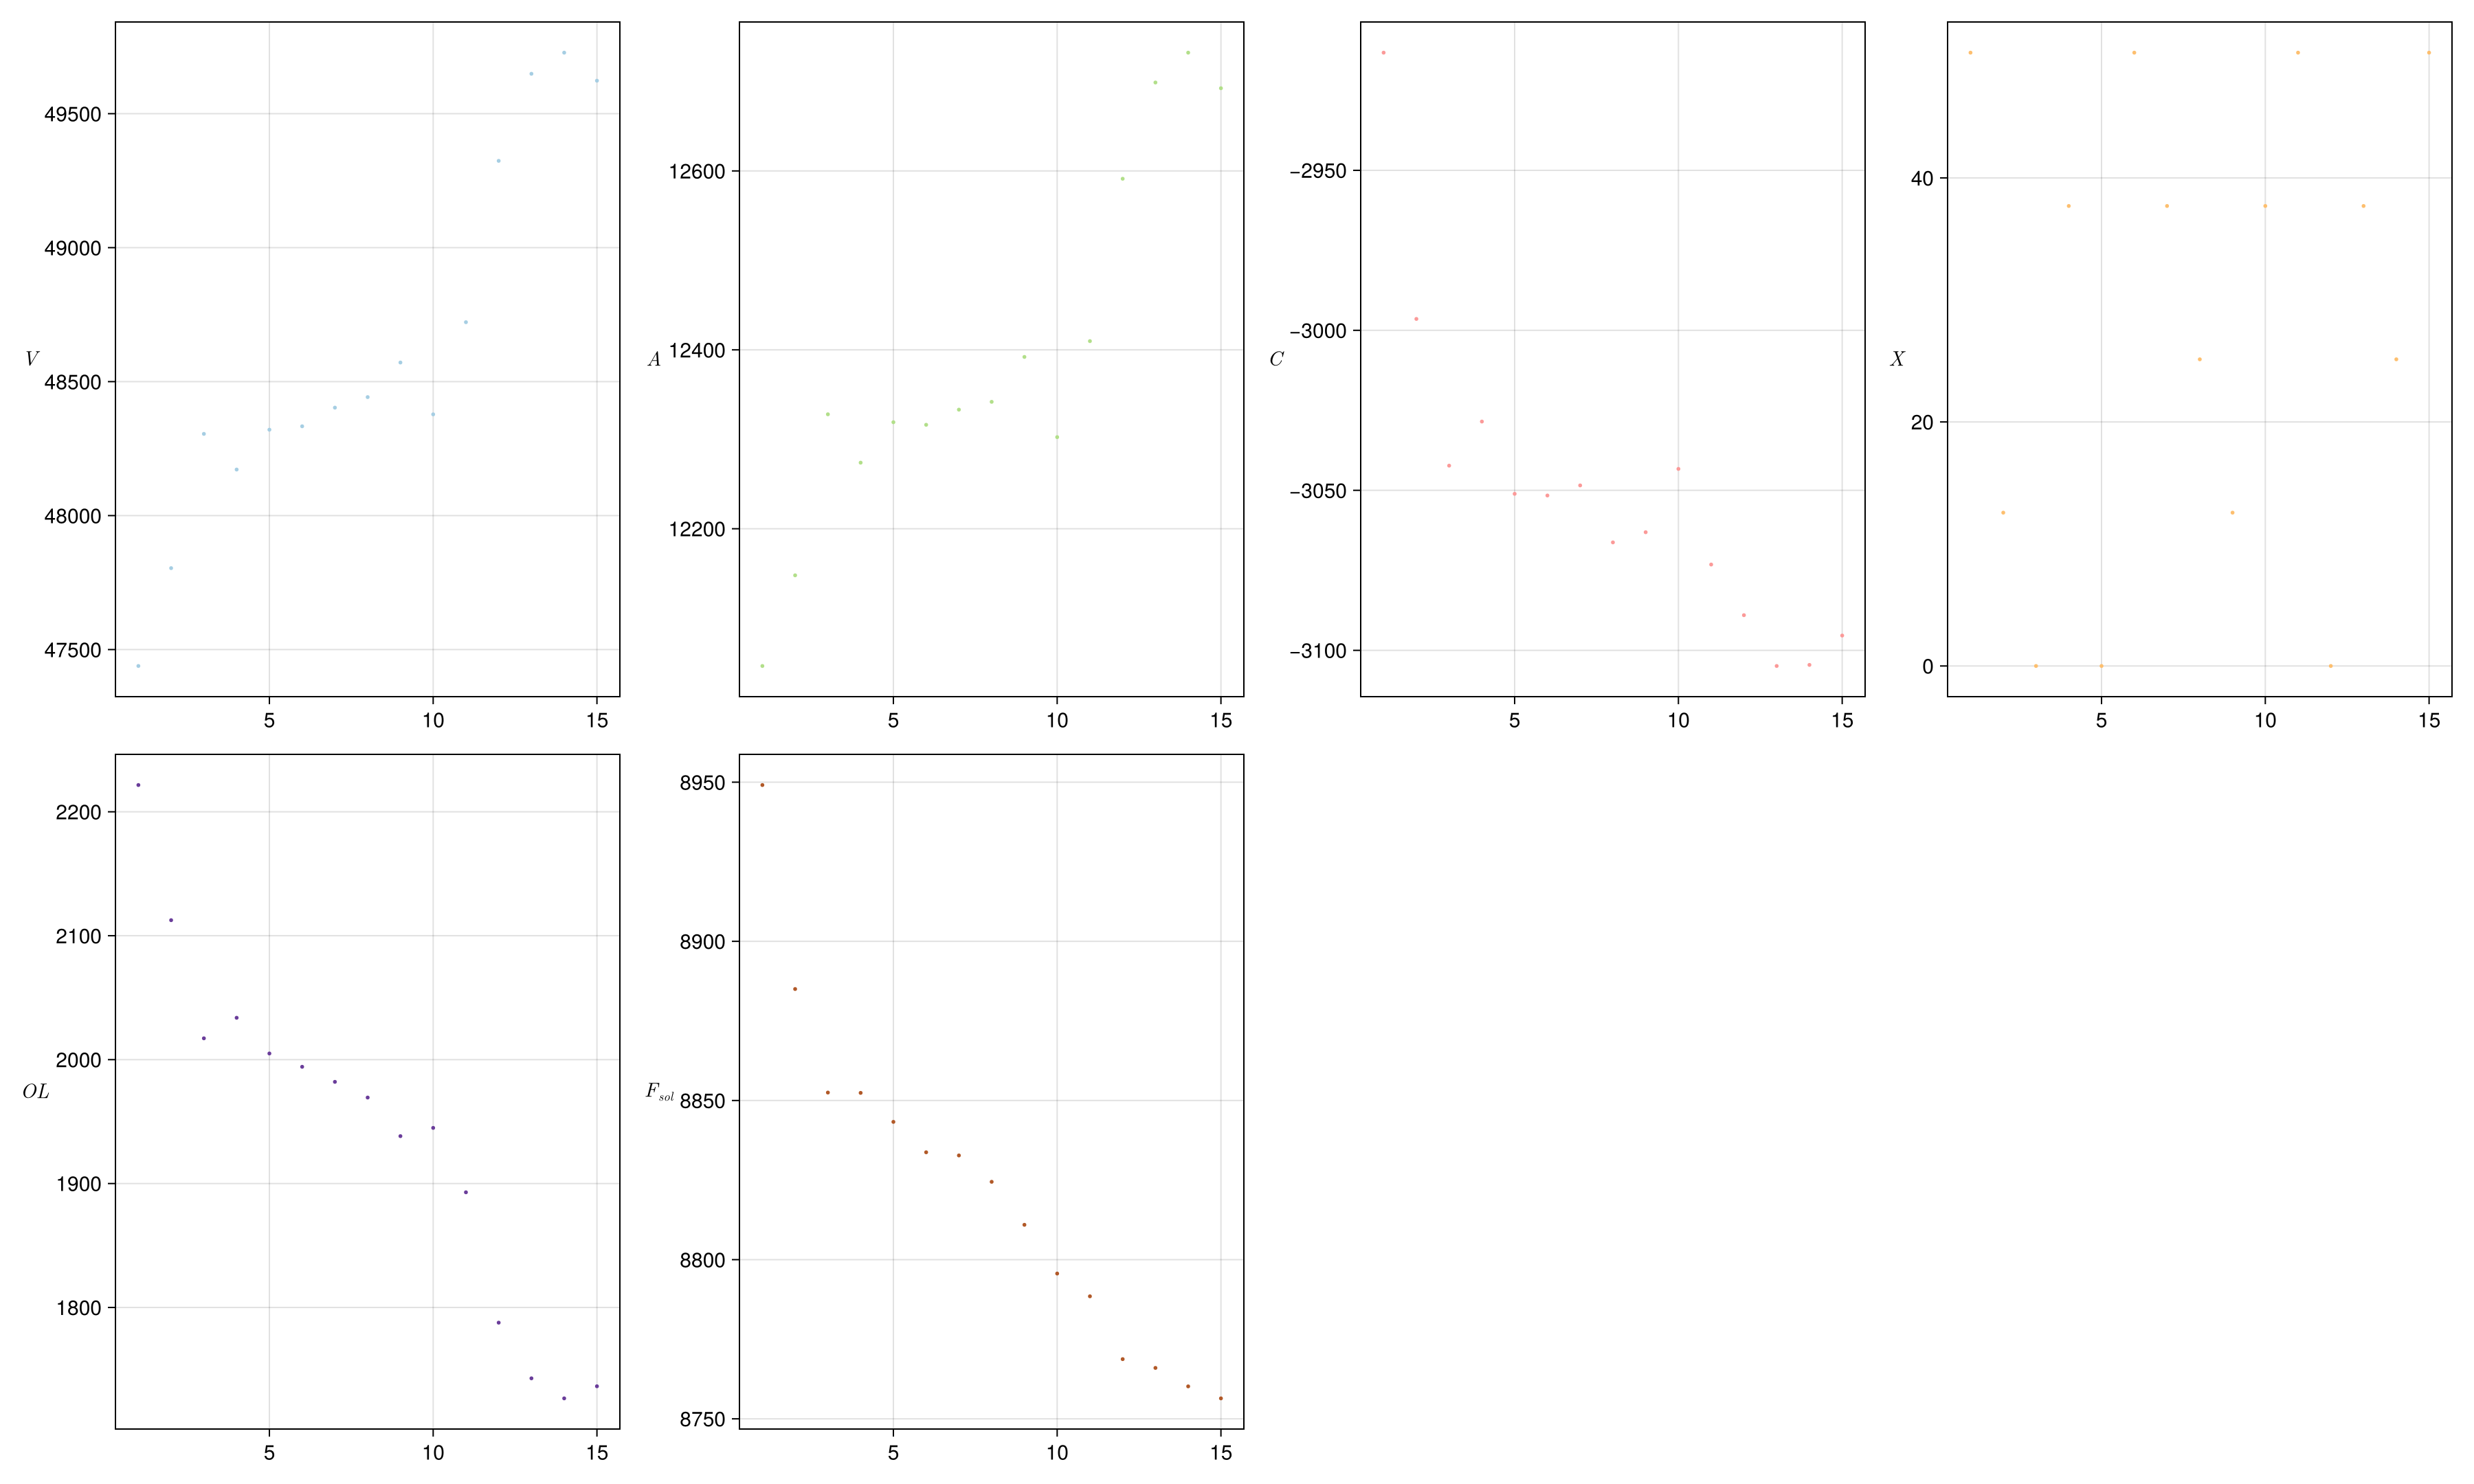

In [11]:
generate_ouput_plots(output)